In [1]:
%env API_USERNAME=codification-ape
%env API_PASSWORD=codification-sirene4

env: API_USERNAME=codification-ape
env: API_PASSWORD=codification-sirene4


In [13]:
!pip install plotnine

import requests
import pandas as pd
import os
import s3fs
import numpy as np
from urllib.parse import urlencode
from plotnine import *


In [3]:
def query_batch_api(username: str, password: str, data: pd.DataFrame, nb_echos_max:int = 5, prob_min: float = 0.01):
    base_url = "https://codification-ape.lab.sspcloud.fr/predict-batch"
    params = {
        "nb_echos_max": nb_echos_max,
        "prob_min": prob_min
    }
    url = f"{base_url}?{urlencode(params)}"

    # Create the request body as a dictionary from the DataFrame
    request_body = data.to_dict(orient="list")

    response = requests.post(url, json=request_body, auth=(username, password))

    if response.status_code == 200:
        return response.json()
    elif response.status_code == 400:
        print(response.json()["detail"])
    else:
        print("Error occurred while querying the API.")
        return None

In [4]:
df = pd.read_parquet('logs_2023-10-19.parquet')

In [5]:
data = df[["libelleActivite", "natureActivites","liasseType","evenementType","surface"]].rename(columns= {"libelleActivite": "text_description", "natureActivites": "nature", "liasseType": "type_", "evenementType": "event"})


| Valeur | Signification            |
|--------|--------------------------|
| 1      | < 121 ou non renseigné   |
| 2      |  [121 ;400]              |
| 3      |  [401 ;2500]             |
| 4      | > 2500                   |

In [6]:
def categorize_surface(surface):
    try:
        if int(surface) < 121:
            return 1
        elif 120 <= int(surface) <= 399:
            return 2
        elif 400 <= int(surface) <= 2499:
            return 3
        else:
            return 4

    except ValueError:
        if surface != "null":
            print(surface)
        return 1

In [7]:
data['surface'] = data['surface'].apply(categorize_surface)

activité de soutien au spectacle vivant
4799B
vente par internet
4799a
vente par internet


In [8]:
data.loc[~data['event'].str.contains(r"^\d{2}[PMF]$"), 'event'] += 'P'
data.reset_index(drop=True, inplace=True)

In [10]:
username = os.getenv("API_USERNAME")
password = os.getenv("API_PASSWORD")
result = query_batch_api(username, password, data, prob_min=0.0)

In [11]:
x = pd.merge(data, pd.DataFrame({
                                "code_1": [result[i]["1"]["code"] for i in range(len(result))],
                                "proba":  [result[i]["1"]["probabilite"] for i in range(len(result))],
                                "IC":     [result[i]["IC"]for i in range(len(result))],
                                "code_2": [result[i]["2"]["code"] for i in range(len(result))],
                                "code_3": [result[i]["3"]["code"] for i in range(len(result))],
                                "code_4": [result[i]["4"]["code"] for i in range(len(result))],
                                "code_5": [result[i]["5"]["code"] for i in range(len(result))]
                                
                            }),
        left_index=True, right_index=True)


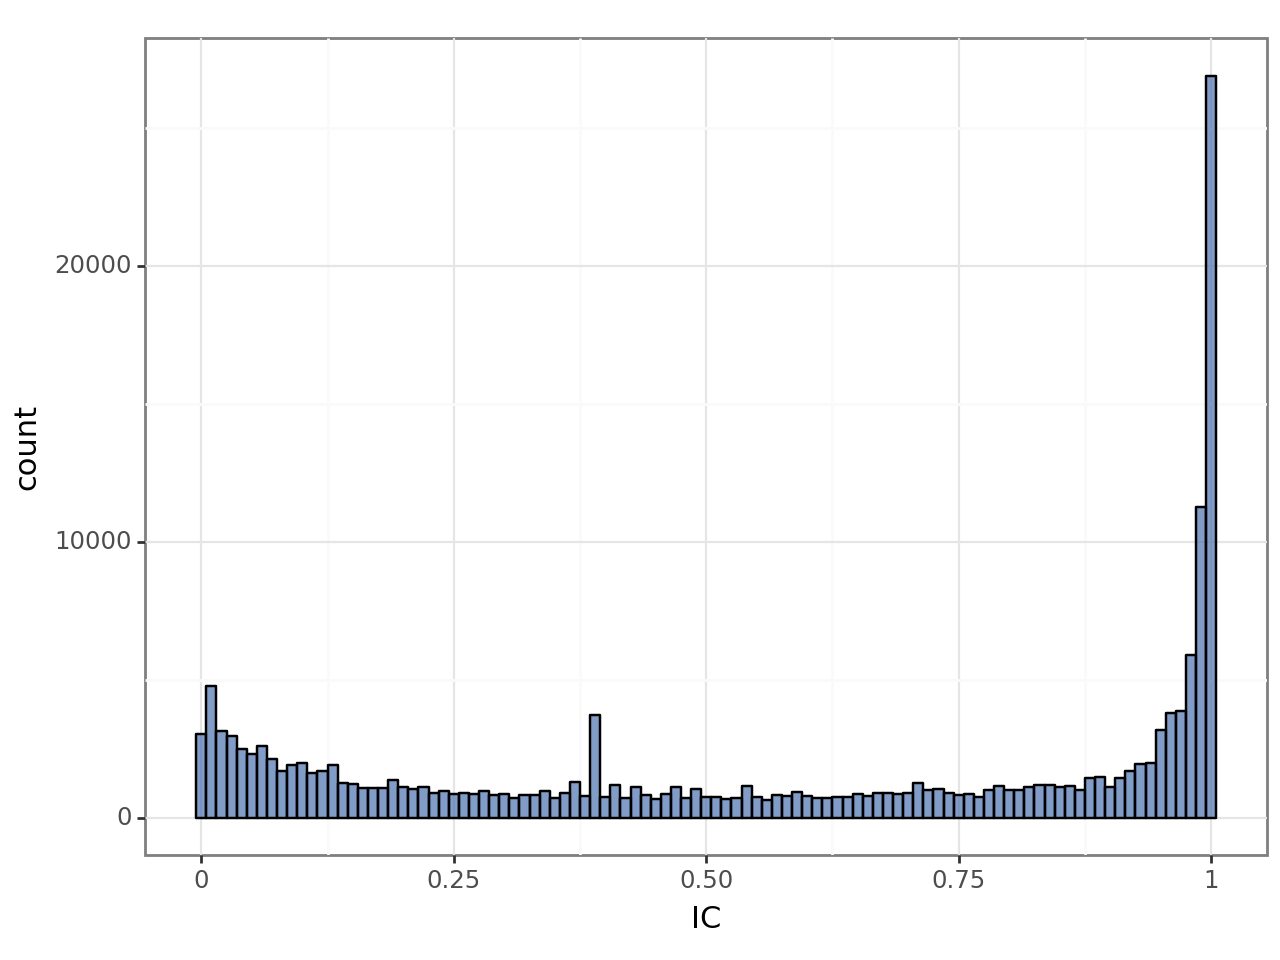

In [14]:
# Créez un DataFrame avec des données aléatoires
# Utilisez plotnine pour créer le plot de distribution
plot = (
    ggplot(x, aes(x='IC')) +
    geom_histogram(binwidth=0.01, fill='#4C72B0', color='black', alpha=0.7, position="identity")+
    theme_bw()
    # Ajoutez d'autres couches si nécessaire (par exemple, des étiquettes, un titre, etc.)
    # Pour ajouter une ligne de distribution gaussienne, vous pouvez utiliser `geom_density()`
)

# Affichez le plot
print(plot)

In [15]:
df.head()

,timestamp,sourceAppel,libelleActivite,natureActivites,liasseType,evenementType,surface,libelleNettoye,prediction_1,proba_1,prediction_2,proba_2,bilan,fasttextVersion
0,2023-10-06 00:06:22.089,WF,livraison de repas uber eats,99,C,01P,null,livraison rep uber eat AUTO_C NAT_SICORE_99 SU...,5320Z,1.000010,1085Z,0.000483,Codification réussie avec FastText et un indic...,22d31664a047cddf583a2f8a1075e4da]
1,2023-10-06 00:06:23.193,WF,Installation de réseaux fibre optique et insta...,99,M,01P,null,install reseau fibr optiqu electr AUTO_M NAT_S...,4321A,0.991948,3320D,0.017996,Codification réussie avec FastText et un indic...,22d31664a047cddf583a2f8a1075e4da]
2,2023-10-06 00:06:50.822,WF,Plomberie chauffagiste,null,X,01P,null,plomber chauffag AUTO_X NAT_SICORE_NaN SURF_Na...,4322A,0.979678,8690D,0.008587,Codification réussie avec FastText et un indic...,22d31664a047cddf583a2f8a1075e4da]
3,2023-10-06 00:07:26.746,WF,Ecriture et creation de vidéo et de contenu à ...,null,X,01P,null,ecritur creation video contenu diffus internet...,5911A,0.168867,5911B,0.132974,Échec de la codification FastText,22d31664a047cddf583a2f8a1075e4da]
4,2023-10-06 00:09:41.669,WF,livraison de repas chaud a domicile a velo,99,C,01P,null,livraison rep chaud domicil velo AUTO_C NAT_SI...,5320Z,1.000010,9820Z,0.000010,Codification réussie avec FastText et un indic...,22d31664a047cddf583a2f8a1075e4da]


In [33]:
sample = x.value_counts("code_1").reset_index().head(13)
sample["code_1"] = pd.Categorical(sample["code_1"], categories=sample["code_1"])

plot = (
    ggplot(sample, aes(x='code_1', y='count/len(x)')) +
    geom_bar(stat='identity', fill='#4C72B0', color='black', alpha=0.7) + 
    scale_y_continuous(labels=lambda x: [f'{val*100}%' for val in x])
)

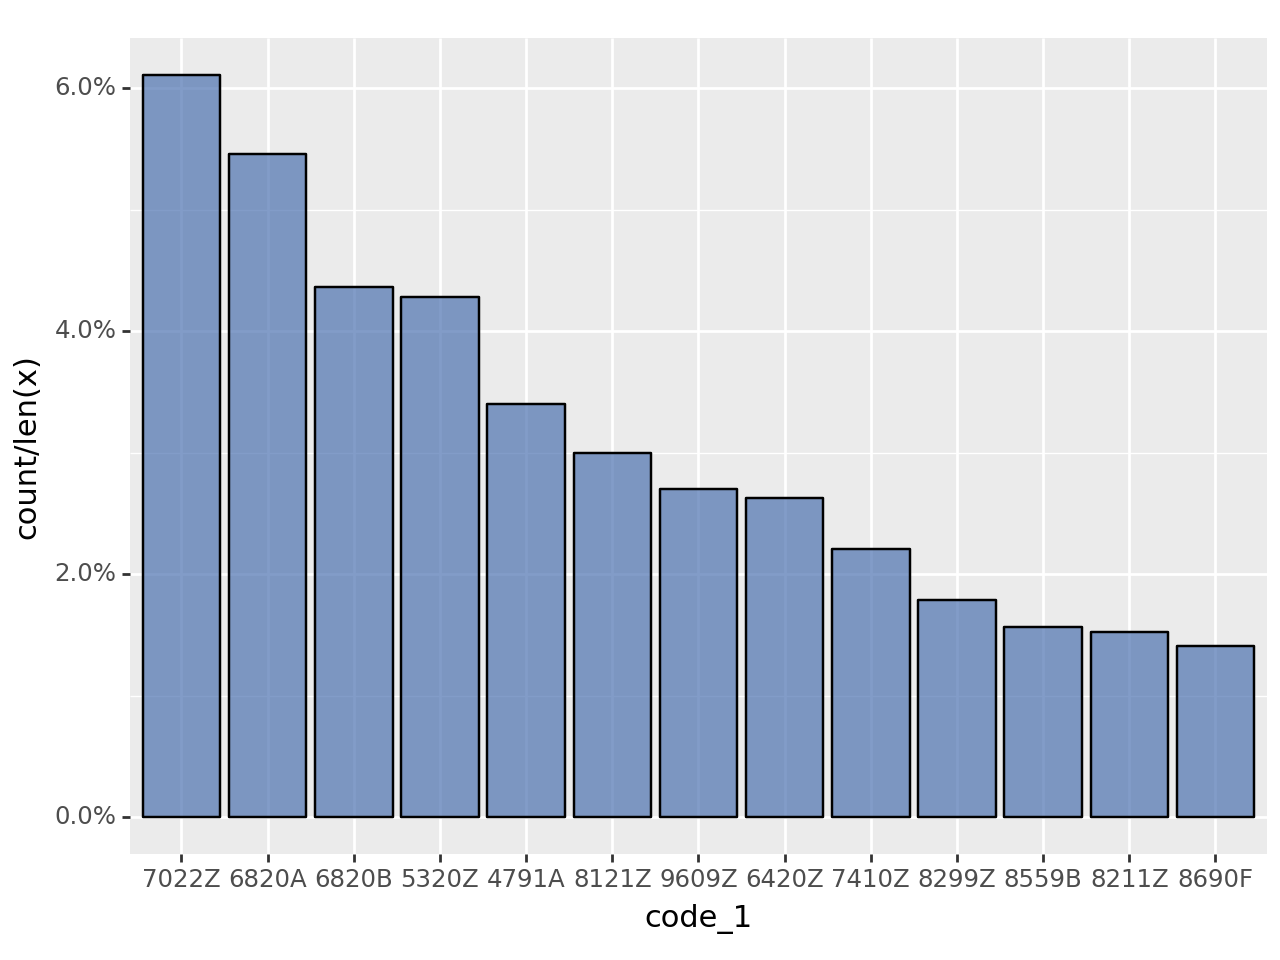

<Figure Size: (640 x 480)>

In [34]:
plot

In [55]:
failed_threshold_but_ok = (x.IC < 0.8) & (x.proba > 0.5) & ((x.proba - x.IC) < 0.1)
# Proba 1 sup à 0.5 et Proba 2 inf à 0.1
failed_threshold_and_hesitating = (x.IC < 0.3) & ((x.proba - x.IC) > 0.25)
# IC inf à 0.3 et Proba 2 sup à 0.25
all_ = (x.IC < 2)
# All
failed_hesitating_4 = (x.code_1.str[:4] == x.code_2.str[:4]) & (x.IC < 0.8)
failed_hesitating_3 = (x.code_1.str[:3] == x.code_2.str[:3]) & (x.IC < 0.8)
failed_hesitating_2 = (x.code_1.str[:2] == x.code_2.str[:2]) & (x.IC < 0.8)

In [74]:
def plot_histo(data, idx, relative_y=True):

    sample = data.loc[idx].value_counts("code_1").reset_index().head(13)
    sample["code_1"] = pd.Categorical(sample["code_1"], categories=sample["code_1"])

    y = 'count/len(data)' if relative_y  else 'count'

    plot = (
        ggplot(sample, aes(x='code_1', y=y)) +
        geom_bar(stat='identity', fill='#4C72B0', color='black', alpha=0.7) + 
        scale_y_continuous(labels=lambda x: [f'{val*100}%' if relative_y else f'{val}' for val in x])
    )
    return plot

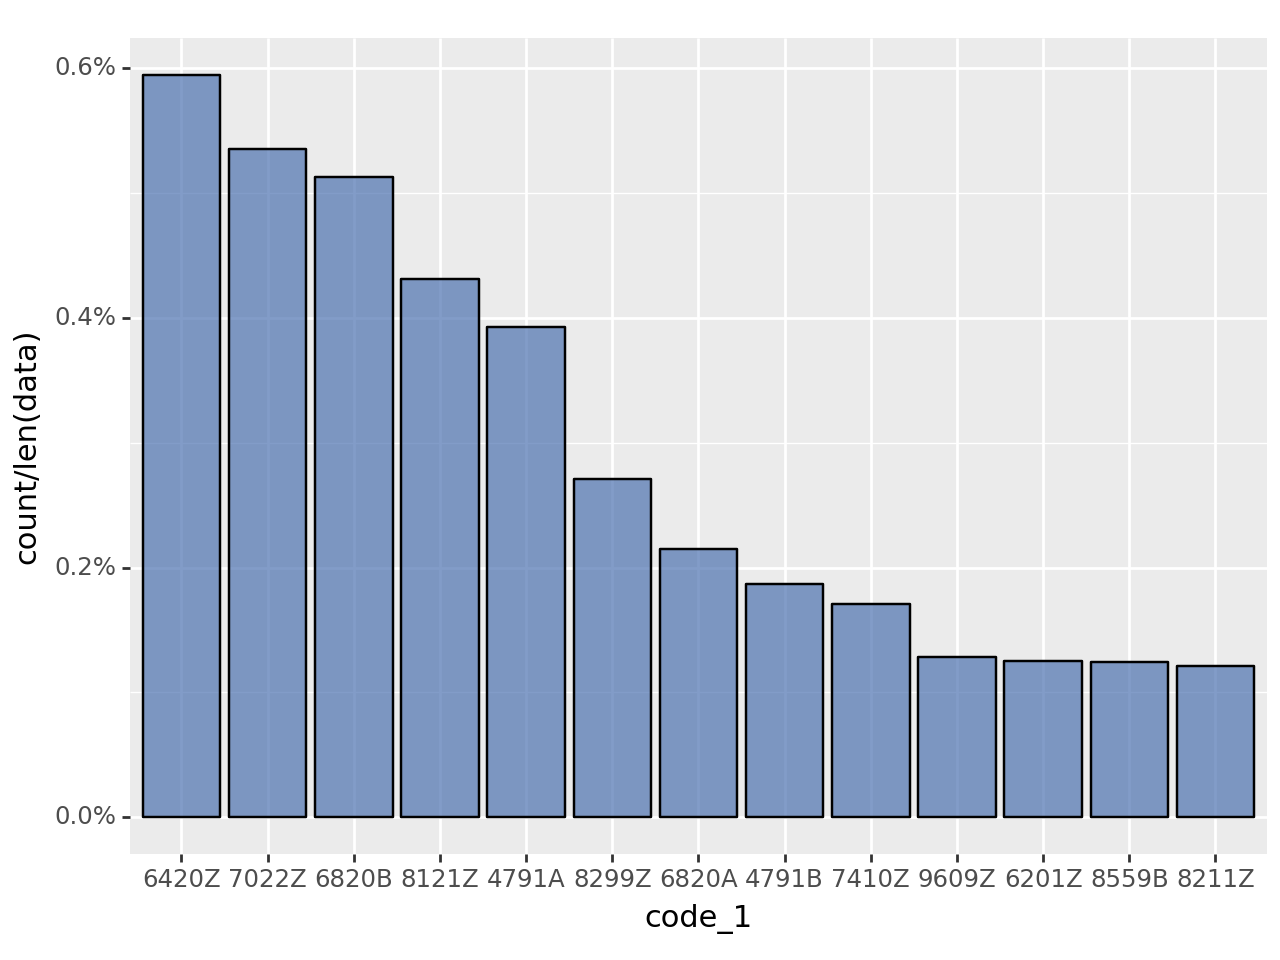

<Figure Size: (640 x 480)>

In [79]:
plot_histo(x, failed_threshold_but_ok, relative_y=True)

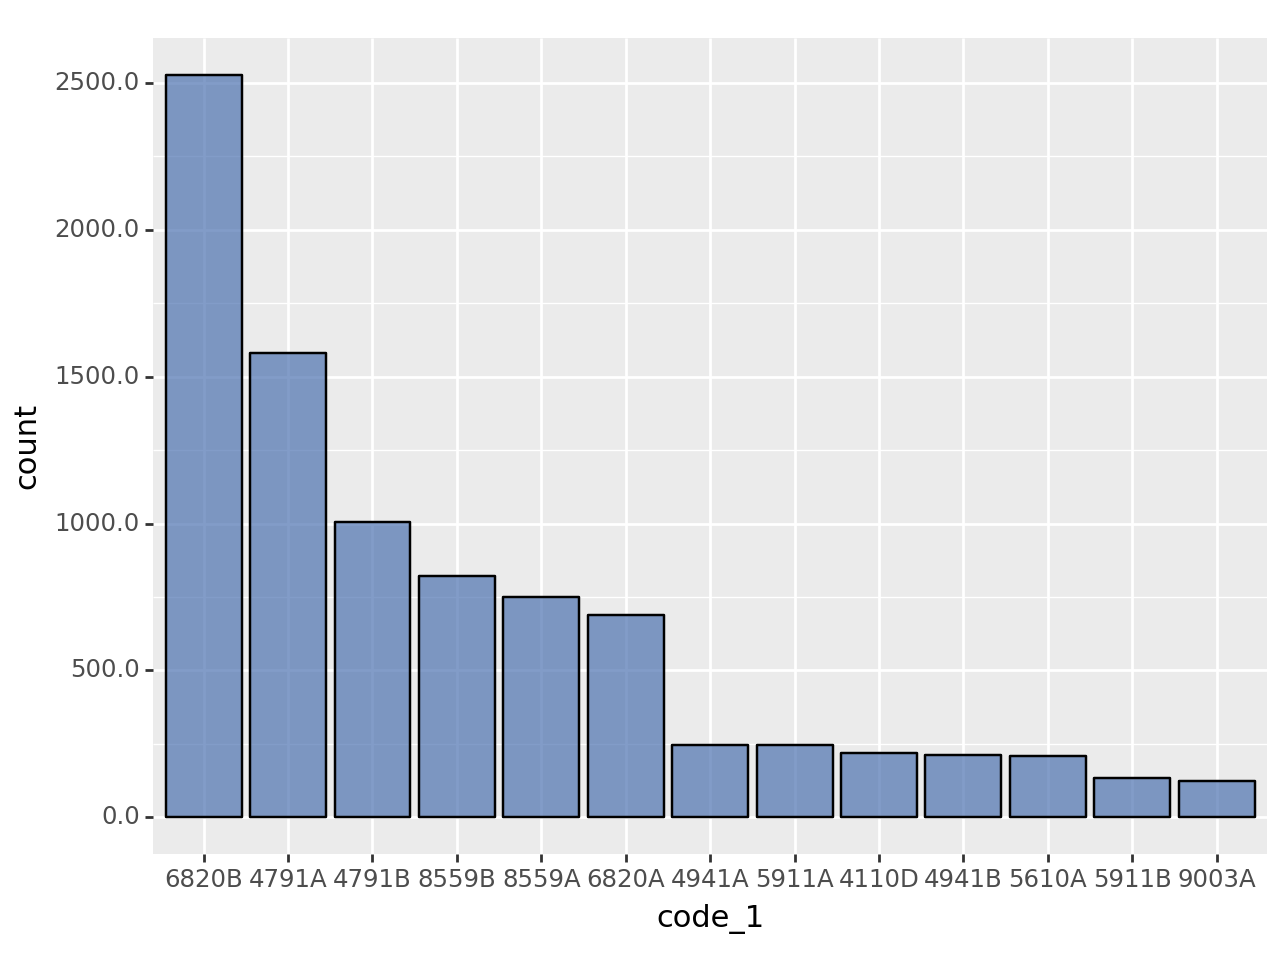

<Figure Size: (640 x 480)>

In [82]:
plot_histo(x, failed_hesitating_4, relative_y=False)

In [86]:
x.loc[failed_hesitating_4].value_counts("code_1").sum()

10201

In [92]:
len(x.loc[failed_hesitating_2])/len(x.loc[(x.IC < 0.8)])

0.2980649062688974

In [84]:
len(x)

173747

In [88]:
x.loc[(x.IC < 0.8)]

,text_description,nature,type_,event,surface,code_1,proba,IC,code_2,code_3,code_4,code_5
3,Ecriture et creation de vidéo et de contenu à ...,null,X,01P,1,5814Z,0.362979,0.021387,5911A,5911B,6209Z,6201Z
8,loueur en meublé non professionnel,null,C,01F,1,5520Z,0.936295,0.428473,6820A,5610C,6831Z,9820Z
11,FABRICATION D'OBJETS DECORATIFS - PALETTES,04,M,01P,1,1629Z,0.843905,0.406072,3299Z,1624Z,3109B,3240Z
13,Realisations de prestations diverses et ponctu...,99,C,01P,1,9001Z,0.294225,0.049130,9609Z,7022Z,8211Z,6201Z
17,Vente en ligne de produits cosmétiques et de p...,99,M,01P,1,4791A,0.712242,0.676012,4791B,4775Z,5610C,9609Z
...,...,...,...,...,...,...,...,...,...,...,...,...
173735,préparation de repas,04,M,01P,1,5610C,0.651365,0.566256,1085Z,5621Z,9511Z,1013A
173736,"""L'acquisition",null,G,01M,1,6820B,0.392347,0.388630,4719B,4777Z,6820A,6499Z
173740,préparation de repas,04,M,01P,1,5610C,0.651365,0.566256,1085Z,5621Z,9511Z,1013A
173742,Formatrice pour des élèves qui prépare un cap ...,null,X,01P,1,8532Z,0.859674,0.398647,8559B,8559A,9602A,8899B
